In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn import metrics


In [4]:
#reading data
data = pd.read_csv('titanic.csv')

In [5]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
data.shape

(891, 12)

In [7]:
data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [8]:
data.drop('PassengerId', axis= 1, inplace = True)

In [9]:
data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [10]:
data.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Lindqvist, Mr. Eino William",male,347082,G6,S
freq,1,577,7,4,644


In [11]:
data.size

9801

In [12]:
data.isnull().values.sum()

866

In [13]:
#Null value in each column
data.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [14]:
#filling null embarked with highest mode class
data['Embarked'] = data['Embarked'].fillna('S')

In [15]:
#to fill missing age, we will use title from name to correctly calculate age. 
data['Prefix'] = data['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]

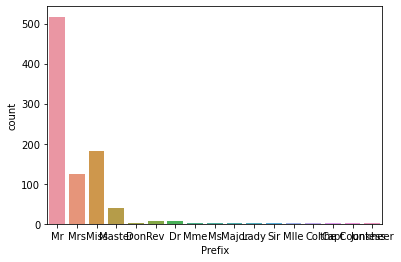

In [16]:
sns.countplot(data = data, x= 'Prefix')

In [17]:
#there are way too many insignificant title, only keeping frequent(frequency more than 10)
prefix_index = (data['Prefix'].value_counts() < 10)

In [18]:
data['Prefix'] = data['Prefix'].apply(lambda x: 'Others' if prefix_index.loc[x] == True else x)
print(data['Prefix'].value_counts())

Mr        517
Miss      182
Mrs       125
Master     40
Others     27
Name: Prefix, dtype: int64


In [19]:
#now filling null age with average age of respective Prefix 
data['Age'] = data['Age'].fillna(data.groupby('Prefix')['Age'].transform('mean'))

In [20]:
data.drop('Name', axis=1, inplace=True) 

In [21]:
data.loc[data['Cabin'].notnull(), 'Cabin_alpha'] = data['Cabin'].str[0]

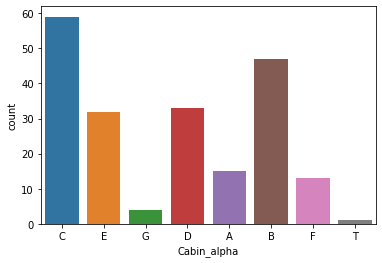

In [22]:
sns.countplot(data = data, x= 'Cabin_alpha')

In [23]:
#pivoting class vs cabin
data[['Cabin_alpha','Pclass']].pivot_table(index='Cabin_alpha', columns='Pclass', 
                        aggfunc=len, fill_value=0)

Pclass,1,2,3
Cabin_alpha,,,
A,15,0,0
B,47,0,0
C,59,0,0
D,29,4,0
E,25,4,3
F,0,8,5
G,0,0,4
T,1,0,0


In [24]:
data['Cabin_alpha'] = data['Cabin_alpha'].replace(np.nan, 'No Cabin', regex=True)

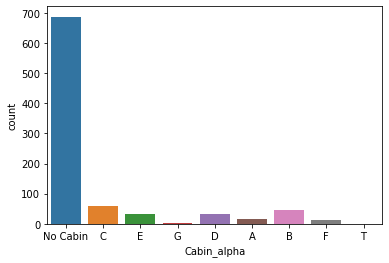

In [25]:
sns.countplot(data = data, x= 'Cabin_alpha')

In [26]:
data.drop('Cabin', axis=1, inplace=True) 

In [27]:
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Prefix,Cabin_alpha
0,0,3,male,22.0,1,0,A/5 21171,7.2500,S,Mr,No Cabin
1,1,1,female,38.0,1,0,PC 17599,71.2833,C,Mrs,C
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss,No Cabin
3,1,1,female,35.0,1,0,113803,53.1000,S,Mrs,C
4,0,3,male,35.0,0,0,373450,8.0500,S,Mr,No Cabin


In [28]:
#droping ticket column as it doesnot provide any new information, we already have ticket class and fare information.
data.drop('Ticket', axis=1, inplace=True) 

## EDA

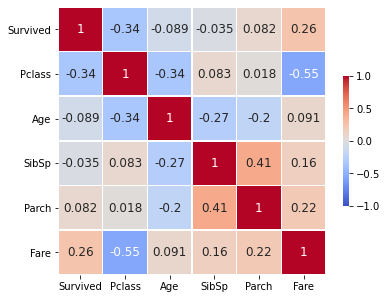

In [29]:
corr_matrix = data.corr()
f, ax = plt.subplots(figsize=(6, 6)) 
heatmap = sns.heatmap(corr_matrix, 
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4, 
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1, 
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 12})
#add the column names as labels
ax.set_yticklabels(corr_matrix.columns, rotation = 0)
ax.set_xticklabels(corr_matrix.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

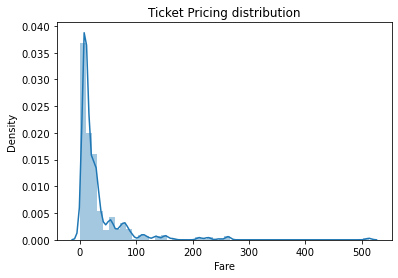

In [30]:
fares= sns.distplot(data['Fare'])
fares.set(xlabel='Fare', ylabel='Density', title = "Ticket Pricing distribution")
plt.show()

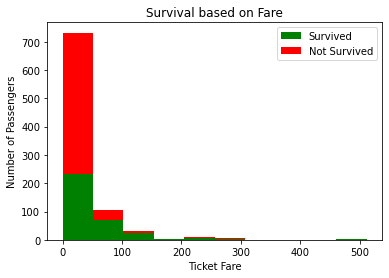

In [31]:
#Survival based on Fare
plt.hist(x = [data[data['Survived']==1]['Fare'], data[data['Survived']==0]['Fare']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Survival based on Fare')
plt.xlabel('Ticket Fare')
plt.ylabel('Number of Passengers')
plt.legend(["Survived","Not Survived"])
plt.show()

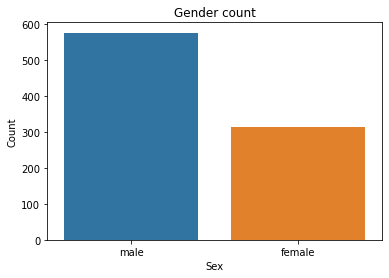

In [32]:
agecount = sns.countplot(x='Sex', data=data)
agecount.set(xlabel='Sex', ylabel='Count', title = "Gender count")
plt.show()

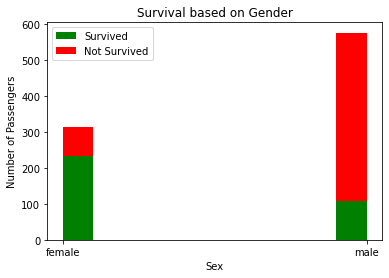

In [33]:
#Survival based on Gender
plt.hist(x = [data[data['Survived']==1]['Sex'], data[data['Survived']==0]['Sex']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Survival based on Gender')
plt.xlabel('Sex')
plt.ylabel('Number of Passengers')
plt.legend(["Survived","Not Survived"])

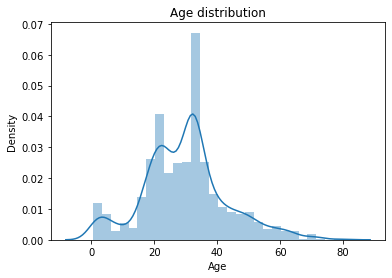

In [34]:
agedist = sns.distplot(data['Age'])
agedist.set(xlabel='Age', ylabel='Density', title = "Age distribution")
plt.show()

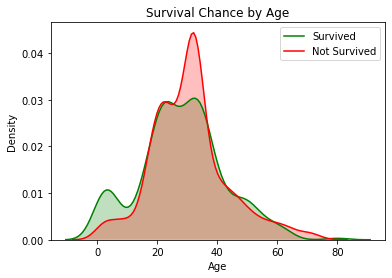

In [35]:
age_sur = sns.kdeplot(data["Age"][(data["Survived"] == 1) & (data["Age"].notnull())], color="Green", shade = True)
age_sur = sns.kdeplot(data["Age"][(data["Survived"] == 0) & (data["Age"].notnull())], ax = age_sur, color="Red", shade= True)
age_sur.set_xlabel("Age")
age_sur.set_ylabel("Density")
age_sur.set_title("Survival Chance by Age")
age_sur = age_sur.legend(["Survived","Not Survived"])

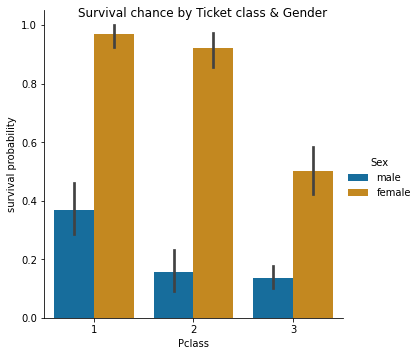

In [36]:
#Survival chances by Ticket Class
Tikclass = sns.catplot(x="Pclass", y="Survived", hue="Sex", data=data,
                   height=5, kind="bar", palette="colorblind")
Tikclass.fig.suptitle("Survival chance by Ticket class & Gender")
Tikclass = Tikclass.set_ylabels("survival probability")

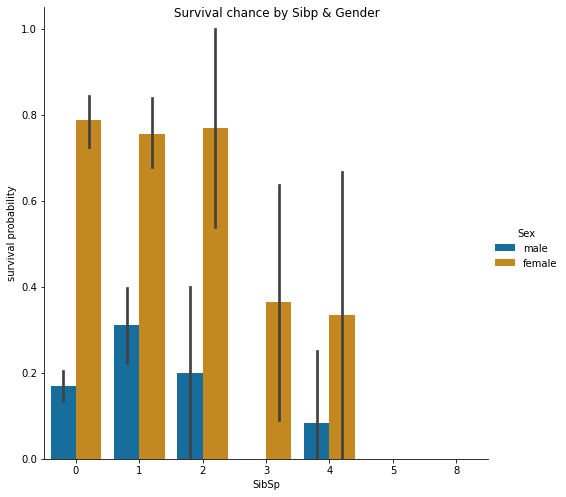

In [37]:
img = sns.catplot(x="SibSp", y="Survived", hue="Sex", data=data,
                   height=7, kind="bar", palette="colorblind")
img.fig.suptitle("Survival chance by Sibp & Gender")
img = img.set_ylabels("survival probability")

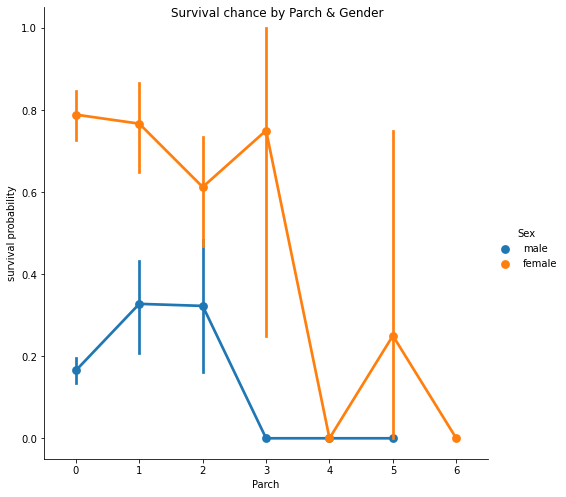

In [38]:
img = sns.catplot(x="Parch", y="Survived", hue="Sex", data=data,
                   height=7, kind="point")
img.fig.suptitle("Survival chance by Parch & Gender")

img = img.set_ylabels("survival probability")

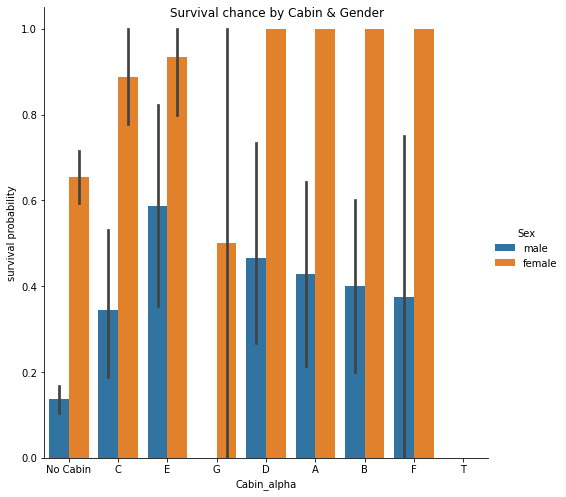

In [39]:
img = sns.catplot(x="Cabin_alpha", y="Survived", hue="Sex", data=data,
                   height=7, kind="bar")
img.fig.suptitle("Survival chance by Cabin & Gender")

img = img.set_ylabels("survival probability")

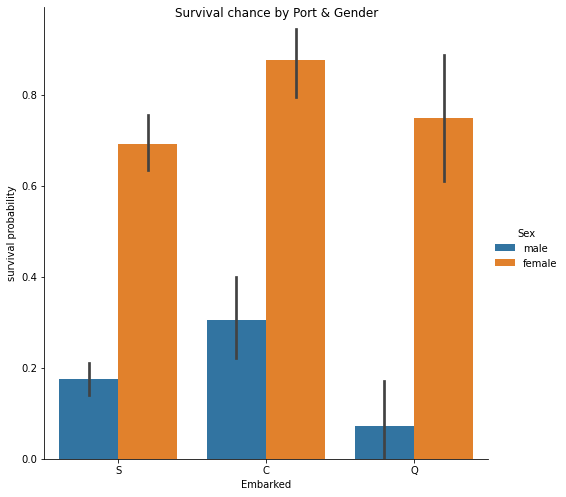

In [40]:
img = sns.catplot(x="Embarked", y="Survived", hue="Sex", data=data,
                   height=7, kind="bar")
img.fig.suptitle("Survival chance by Port & Gender")

img = img.set_ylabels("survival probability")

## Changing Categorical variable for compatibility 

In [41]:
data.dtypes

Survived         int64
Pclass           int64
Sex             object
Age            float64
SibSp            int64
Parch            int64
Fare           float64
Embarked        object
Prefix          object
Cabin_alpha     object
dtype: object

In [42]:
mapper = {'male': 0, 'female':1}
data['Sex'] = data['Sex'].replace(mapper)

In [43]:
data = pd.get_dummies(data, prefix= ['Embarked'], columns = ['Embarked'])
data = data.drop(['Embarked_S'], axis = 1)    #droping one encoding

In [44]:
data = pd.get_dummies(data, prefix= ['Title'], columns = ['Prefix'])
data = data.drop(['Title_Others'], axis = 1)    #droping one encoding

In [45]:
data = pd.get_dummies(data, prefix= ['Cabin'], columns = ['Cabin_alpha'])
data = data.drop(['Cabin_C'], axis = 1)     #droping one encoding


## Modeling

In [46]:
#dividing target variable from feature variables
X = data.drop(columns='Survived')
y = data.Survived

In [47]:
#spliting dataset to testing and trainning set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 21)

In [48]:
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.fit_transform(X_test)

In [49]:
model1 = DecisionTreeClassifier(max_leaf_nodes= 6, random_state = 21)
model1.fit(X_train, y_train)

DecisionTreeClassifier(max_leaf_nodes=6, random_state=21)

In [50]:
y_pred1= model1.predict(X_test)

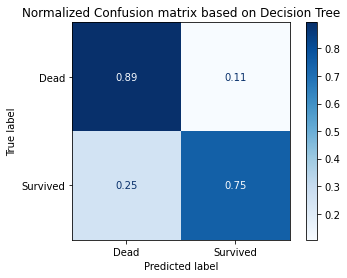

In [51]:
plot_confusion_matrix(model1, X_test, y_test, cmap=plt.cm.Blues, normalize='true', display_labels= ["Dead", 'Survived'])  
plt.title("Normalized Confusion matrix based on Decision Tree")
plt.show()

In [52]:
accuracy_score(y_test, y_pred1)

0.835820895522388

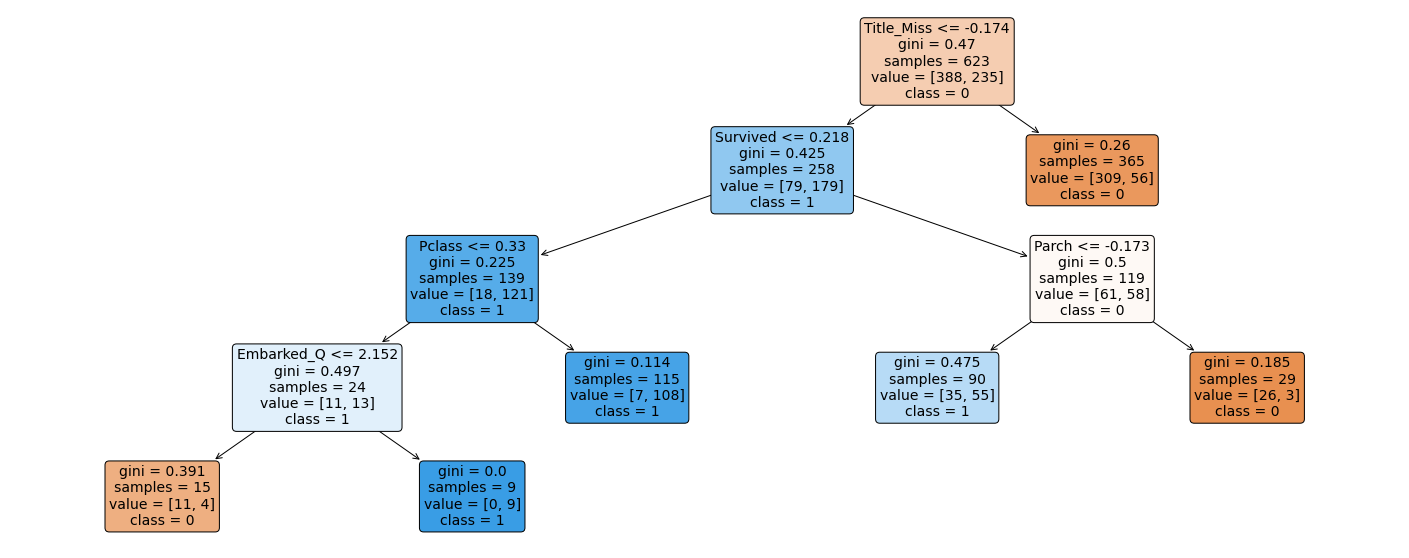

In [53]:
plt.figure(figsize=(25,10))
plot=tree.plot_tree(model1, feature_names= data.columns.values.tolist(),
                   class_names=['0','1'], filled = True, rounded= True, fontsize= 14)

In [54]:
#model2 
model2 = RandomForestClassifier(max_depth=2, random_state=21)
model2.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, random_state=21)

In [55]:
y_pred2= model2.predict(X_test)

In [56]:
accuracy_score(y_test, y_pred2)

0.7947761194029851

In [57]:
#model3
model3 = LogisticRegression(random_state = 21)
model3.fit(X_train, y_train)


LogisticRegression(random_state=21)

In [58]:
y_pred3= model3.predict(X_test)

In [59]:
accuracy_score(y_test, y_pred3)

0.832089552238806

In [60]:
model4 =GradientBoostingClassifier(random_state = 21)
model4.fit(X_train, y_train)

GradientBoostingClassifier(random_state=21)

In [61]:
y_pred4= model4.predict(X_test)

In [62]:
accuracy_score(y_test, y_pred4)

0.8283582089552238

**Please find report file for detail of this prediction model.** 

*Need to add markdown on notebook file